In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn.objects as so
import seaborn as sns
import numpy as np

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import image_dataset_from_directory

### Stragety

In [2]:
stragety = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


In [3]:
print(f"Numbers of GPU: {stragety.num_replicas_in_sync}")

Numbers of GPU: 2


### Reading the data

In [4]:
w_dir = pathlib.Path('/home/antirrabia/Documents/DeepLearnin/DATASETS/CatsVsDogs/cats_vs_dogs_small/')

In [5]:
tr_d = image_dataset_from_directory(
    w_dir / 'train',
    image_size=(180,180)
)

va_d = image_dataset_from_directory(
    w_dir / 'validation',
    image_size=(180,180)
)

te_d = image_dataset_from_directory(
    w_dir / 'test',
    image_size=(180,180)
)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [6]:
AUTOTUNE = tf.data.AUTOTUNE

tr_d = tr_d.prefetch(buffer_size=AUTOTUNE)
va_d = va_d.prefetch(buffer_size=AUTOTUNE)
te_d = te_d.prefetch(buffer_size=AUTOTUNE)

### Data augmentation

In [7]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip('horizontal'),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2)
    ]
)

### The model

In [14]:
with stragety.scope():
    inputs = keras.Input(shape=(180,180,3))
    
    x = data_augmentation(inputs)
    x = layers.Rescaling(1./255)(x)
    
    x = layers.Conv2D(32, 5, use_bias=False)(x)
    
    for size in [32,64,128,256,512]:
        residual = x
        
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)
        
        x = layers.Conv2D(size, 3, padding='same', use_bias=False)(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)
        
        x = layers.Conv2D(size, 3, padding='same', use_bias=False)(x)
        
        x = layers.MaxPooling2D(3, strides=2, padding='same')(x)
        
        residual = layers.Conv2D(size, 1, strides=2, padding='same', use_bias=False)(residual)
        
        x = layers.add([x, residual])
        
    x = layers.GlobalMaxPooling2D()(x)
    x = layers.Dropout(0.6)(x)
    
    outputs = layers.Dense(1, activation='sigmoid')(x)
    
    model = keras.Model(inputs, outputs)
    
    model.compile(
        optimizer='rmsprop',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )                  

In [18]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath='distri_batchN_residual.keras',
        save_best_only=True,
        monitor='val_loss'
    )
]

history = model.fit(
    tr_d,
    epochs=106,
    validation_data=va_d,
    callbacks=callbacks
)

Epoch 1/106
63/63 [==============================] - 9s 140ms/step - loss: 0.2973 - accuracy: 0.8685 - val_loss: 0.3236 - val_accuracy: 0.8620
Epoch 2/106
63/63 [==============================] - 9s 140ms/step - loss: 0.3041 - accuracy: 0.8690 - val_loss: 0.3058 - val_accuracy: 0.8640
Epoch 3/106
63/63 [==============================] - 8s 135ms/step - loss: 0.2847 - accuracy: 0.8875 - val_loss: 0.3775 - val_accuracy: 0.8380
Epoch 4/106
63/63 [==============================] - 9s 138ms/step - loss: 0.2782 - accuracy: 0.8895 - val_loss: 1.0254 - val_accuracy: 0.6910
Epoch 5/106
63/63 [==============================] - 9s 138ms/step - loss: 0.2721 - accuracy: 0.8900 - val_loss: 0.4816 - val_accuracy: 0.7910
Epoch 6/106
63/63 [==============================] - 9s 140ms/step - loss: 0.2461 - accuracy: 0.8985 - val_loss: 0.6023 - val_accuracy: 0.7750
Epoch 7/106
63/63 [==============================] - 9s 139ms/step - loss: 0.2800 - accuracy: 0.8825 - val_loss: 0.3916 - val_accuracy: 0.8230

### Plotting the training

Text(0.5, 1.0, 'Training and Validation Loss')

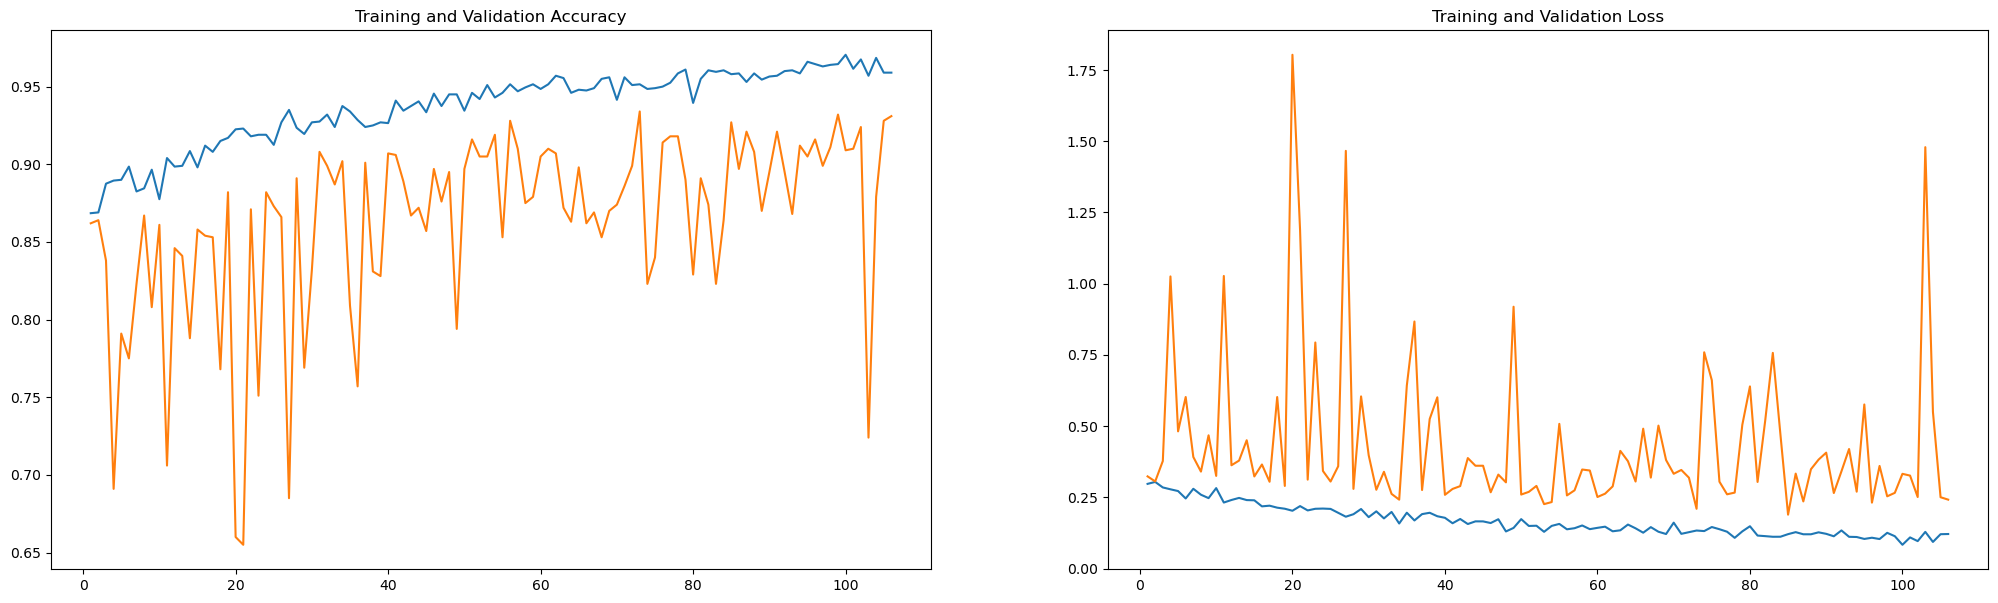

In [19]:
accuracy = history.history['accuracy']
val_accu = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epoch = range(1, len(accuracy)+1)

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(25,7))

ax[0].plot(epoch, accuracy, label='Training Accuracy')
ax[0].plot(epoch, val_accu, label='Validation Accuracy')
ax[0].set_title('Training and Validation Accuracy')

ax[1].plot(epoch, loss, label='Training Loss')
ax[1].plot(epoch, val_loss, label='Validation Loss')
ax[1].set_title('Training and Validation Loss')

### Testing the model

In [20]:
te_model = keras.models.load_model('distri_batchN_residual.keras')

te_loss, te_accuracy = te_model.evaluate(te_d)

print(f"Test accuracy: {te_accuracy:.3f}")

63/63 [==============================] - 3s 47ms/step - loss: 0.3190 - accuracy: 0.9060
Test accuracy: 0.906
